In [1]:
"""Author: Sameer Kesava

Estimating the variance in the data using Bootstrap. 

Implementing Parallel Processing using Multiprocessing package.

Portfolio dataset containing returns of two assets X and Y.
Objective is to estimate ratio of investment f/(1-f) between the two.
Considering the variance in X and Y, the objective function is to minimize Variance (fX + (1-f)Y).

f is a function of variance of X, Y and XY (refer to book below). 

Problem statement from Chapter 5
Book: An Introduction to Statistical Learning with Applications in R, 
       Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani

Dataset: Portfolio (downloaded from https://www-bcf.usc.edu/~gareth/ISL/ and converted to csv)

Packages used: numpy, pandas, sklearn and matplotlib"""

'Author: Sameer Kesava\n\nEstimating the variance in the data using Bootstrap. \n\nImplementing Parallel Processing using Multiprocessing package.\n\nPortfolio dataset containing returns of two assets X and Y.\nObjective is to estimate ratio of investment f/(1-f) between the two.\nConsidering the variance in X and Y, the objective function is to minimize Variance (fX + (1-f)Y).\n\nf is a function of variance of X, Y and XY (refer to book below). \n\nProblem statement from Chapter 5\nBook: An Introduction to Statistical Learning with Applications in R, \n       Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani\n\nDataset: Portfolio (downloaded from https://www-bcf.usc.edu/~gareth/ISL/ and converted to csv)\n\nPackages used: numpy, pandas, sklearn and matplotlib'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
pd.options.display.max_columns = 100

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
data_df = pd.read_csv("Portfolio")
data_df.head(10)

,X,Y
1,-0.895251,-0.234924
2,-1.562454,-0.885176
3,-0.417090,0.271888
4,1.044356,-0.734198
5,-0.315568,0.841983
6,-1.737124,-2.037191
7,1.966413,1.452957
8,2.152868,-0.434139
9,-0.081208,1.450809
10,-0.891782,0.821016


In [5]:
data_df.describe()

,X,Y
count,100.000000,100.000000
mean,-0.077132,-0.096945
std,1.062376,1.143782
min,-2.432764,-2.725281
25%,-0.888474,-0.885722
50%,-0.268889,-0.228708
75%,0.558093,0.806708
max,2.460336,2.565985


In [6]:
#Checking Correlation
data_df.corr(method = 'pearson')

,X,Y
X,1.000000,0.515468
Y,0.515468,1.000000


In [7]:
#Variance and Covariance
cov = data_df.cov()
cov

,X,Y
X,1.128642,0.626358
Y,0.626358,1.308237


### Using Sparse Matrices to store the data generated during parallel processing

#### Lists are appended to directly without creating a new copy unlike numpy arrays. Hence should be more efficient.
#### However, using sparse matrices here

In [8]:
from sys import getsizeof
from scipy.sparse import lil_matrix

In [9]:
bootstrap_num = 1000

In [10]:
cov_arr = lil_matrix((bootstrap_num,3), dtype = 'float32')

In [11]:
getsizeof(cov_arr)

56

In [12]:
#In comparison, initiating a numpy zeros array takes
zeros_arr = np.zeros((bootstrap_num,3), dtype = 'float32')
getsizeof(zeros_arr)

12112

In [13]:
from sklearn.utils import resample

In [14]:
#Sampling data with replacements
def resampling(sparse_arr, index):
    temp = resample(data_df, replace = True, n_samples = len(data_df))
    var_array = temp.cov().values #2D array: Variances of X and Y along the diagonal and covariances along the off-diagonal
    sparse_arr[index] = np.concatenate((var_array.diagonal(), var_array.diagonal(1)))

In [15]:
#Serial Processing
import time
start_time = time.time() #can use timeit but this is easier
for i in range(bootstrap_num): #Serial operation
    resampling(cov_arr, i)

print(cov_arr.toarray()[:5])
end_time = time.time()
print('Time taken: {:.2f}s'.format(end_time-start_time))

[[1.0411153  1.2722979  0.6251851 ]
 [1.2426138  1.1934288  0.52237135]
 [0.857746   0.9831853  0.5390517 ]
 [1.4199594  1.2637153  0.8886996 ]
 [0.77296114 1.1275599  0.4244878 ]]
Time taken: 0.82s


In [16]:
getsizeof(cov_arr)

56

In [17]:
getsizeof(cov_arr.toarray())
#same as zeros array

12112

### Parallel processing 

In [18]:
#Checking the number of cores and threads
import psutil
print('Cores: ', psutil.cpu_count(logical=False))
print('Threads: ', psutil.cpu_count(logical=True))

Cores:  4
Threads:  4


In [19]:
from multiprocessing.pool import ThreadPool

In [20]:
#Multiprocess, Synchronous sampling with replacement
def resampling_sync(sparse_arr, index):
    temp = resample(data_df, replace = True, n_samples = len(data_df))
    var_array = temp.cov().values #2D array: Variances of X and Y along the diagonal and covariances along the off-diagonal
    sparse_arr[index] = np.concatenate((var_array.diagonal(), var_array.diagonal(1)))

cov_arr_pool_sync = lil_matrix((bootstrap_num,3), dtype = 'float32')

def main():
    start_time = time.time()
    [pooling.apply(resampling_sync, args = (cov_arr_pool_sync, i)) for i in range(bootstrap_num)];
    end_time = time.time()
    print('Time taken: {:.2f}s'.format(end_time-start_time))
    print(cov_arr_pool_sync[0].toarray())
    
if __name__ == '__main__':
    pooling = ThreadPool(processes=4)
    main() 

Time taken: 1.18s
[[0.94907165 1.3240218  0.5875494 ]]


In [21]:
#Multiprocess, Asynchronous sampling with replacement

def resampling_async_sparse(sparse_arr, index):
    temp = resample(data_df, replace = True, n_samples = len(data_df))
    var_array = temp.cov().values #2D array: Variances of X and Y along the diagonal and covariances along the off-diagonal
    sparse_arr[index] = np.concatenate((var_array.diagonal(), var_array.diagonal(1)))
    
cov_arr_pool_async = lil_matrix((bootstrap_num,3), dtype = 'float32')

def main():
    [pooling.apply_async(resampling_async_sparse, args = (cov_arr_pool_async, i)) for i in range(bootstrap_num)];
    #executing like above as in sync, results in output as [0,0,0]. 
    #Implies any commands following apply_async are executed while it is being executed
if __name__ == '__main__':
    pooling = ThreadPool(processes=4)    
    start_time = time.time()
    main()
    end_time = time.time()
    print('Time taken: {:.2f}s'.format(end_time-start_time))
    print('{}'.format(np.round_(cov_arr_pool_async[0].toarray(), decimals=3)))

Time taken: 0.01s
[[1.161 1.48  0.746]]


In [22]:
getsizeof(cov_arr_pool_async.toarray())

12112

In [23]:
#Converting to pandas dataframes
df_single_thread = pd.DataFrame(data = cov_arr.toarray(), columns = ['X', 'Y', 'XY'])
df_single_thread.describe()

,X,Y,XY
count,1000.000000,1000.000000,1000.000000
mean,1.119627,1.292084,0.623398
std,0.140114,0.168757,0.113104
min,0.770379,0.788366,0.335519
25%,1.024508,1.171304,0.541678
50%,1.114924,1.280160,0.621827
75%,1.215435,1.406659,0.696315
max,1.596023,1.818903,1.162959


In [24]:
#Sync
df_multithread_sync = pd.DataFrame(data = cov_arr_pool_sync.toarray(), \
                                   columns = ['X', 'Y', 'XY'])
df_multithread_sync.describe()

,X,Y,XY
count,1000.000000,1000.000000,1000.000000
mean,1.118860,1.289308,0.615259
std,0.140195,0.167208,0.114501
min,0.691915,0.754858,0.276954
25%,1.019551,1.173500,0.533961
50%,1.115125,1.281806,0.615634
75%,1.209799,1.396905,0.692177
max,1.674749,1.886309,0.998497


In [25]:
#Async
df_multithread_async = pd.DataFrame(data = cov_arr_pool_async.toarray(), \
                                    columns = ['X', 'Y', 'XY'])
df_multithread_async.describe()

,X,Y,XY
count,1000.000000,1000.000000,1000.000000
mean,0.379765,0.436848,0.213056
std,0.540159,0.621488,0.306821
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.042374,1.193625,0.555584
max,1.547567,1.774634,1.011871


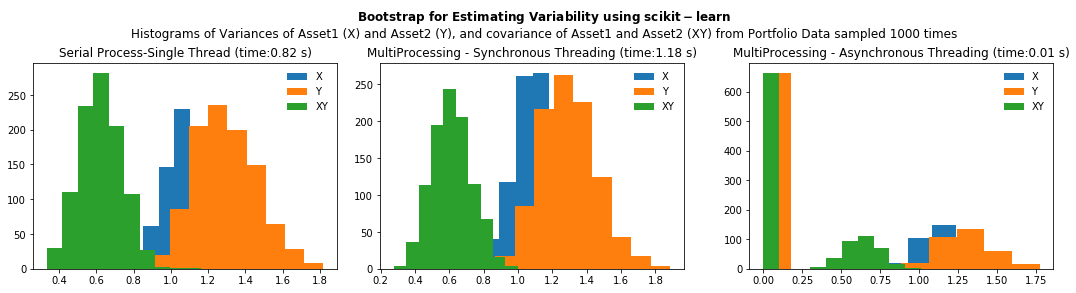

In [35]:
#Plotting the histograms of the variances 
fig, ax = plt.subplots(1,3, figsize=(15,4), constrained_layout =True)
alpha = 0.5 #transparency 

ax[0].hist(df_single_thread['X'])
ax[0].hist(df_single_thread['Y'])
ax[0].hist(df_single_thread['XY'])
ax[0].set_title('Serial Process-Single Thread (time:0.82 s)')

ax[1].hist(df_multithread_sync['X'])
ax[1].hist(df_multithread_sync['Y'])
ax[1].hist(df_multithread_sync['XY'])
ax[1].set_title('MultiProcessing - Synchronous Threading (time:1.18 s)')

ax[2].hist(df_multithread_async['X'])
ax[2].hist(df_multithread_async['Y'])
ax[2].hist(df_multithread_async['XY'])
ax[2].set_title('MultiProcessing - Asynchronous Threading (time:0.01 s)')


lgd0 = ax[0].legend(frameon=False)
lgd1 = ax[1].legend(frameon=False)
lgd2 = ax[2].legend(frameon=False)

fig.suptitle('$\mathbf{Bootstrap\ for\ Estimating\ Variability\ using\ scikit-learn}$'+'\n'+ \
             r'Histograms of Variances of Asset1 (X) and Asset2 (Y), and covariance of Asset1 and Asset2 (XY) from Portfolio Data \
sampled %d times'%(bootstrap_num))
plt.show()

In [36]:
fig.savefig('BootStrap_Portfolio_Data.png', dpi = 100, format = 'png')

#### Standard errors of all the processes are very similar

In [28]:
#Calculating the fraction which represents the minimized risk of choosing X and Y in the form
#frac(X) + (1 - frac)Y
def frac(df):
    return (df['Y'] - df['XY'])/(df['X']+df['Y']-2*df['XY'])

In [29]:
df_single_thread['frac'] = df_single_thread.apply(frac, axis=1)
df_multithread_sync['frac'] = df_multithread_sync.apply(frac, axis=1)
df_multithread_async['frac'] = df_multithread_async.apply(frac, axis=1)

/home/sameer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [30]:
df_single_thread['frac'].describe()

count    1000.000000
mean        0.575892
std         0.090491
min         0.299727
25%         0.514035
50%         0.574832
75%         0.637787
max         0.878735
Name: frac, dtype: float64

In [31]:
df_multithread_sync['frac'].describe()

count    1000.000000
mean        0.574468
std         0.091376
min         0.294362
25%         0.509326
50%         0.572043
75%         0.635484
max         0.895959
Name: frac, dtype: float64

In [32]:
df_multithread_async['frac'].describe()

count    336.000000
mean       0.575144
std        0.090669
min        0.333293
25%        0.520292
50%        0.576072
75%        0.631874
max        0.818258
Name: frac, dtype: float64

/home/sameer/anaconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/sameer/anaconda3/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


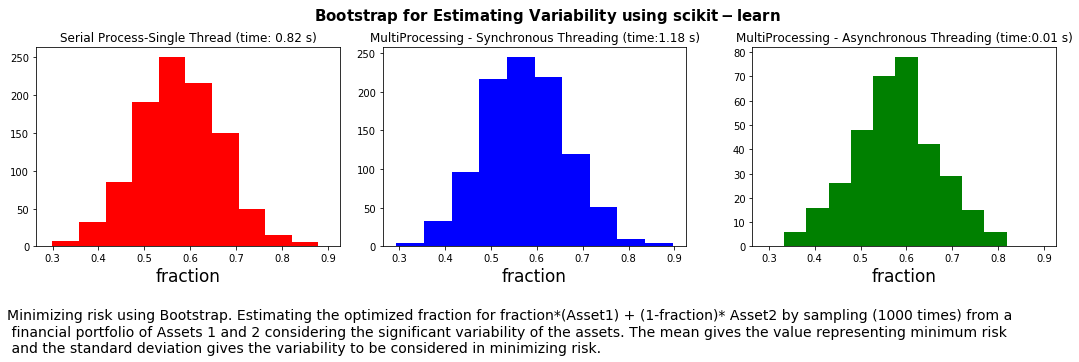

In [37]:
#Plotting the histograms of the fraction  
fig2, ax2 = plt.subplots(1,3, figsize=(15,4), constrained_layout =True, sharex = True) #
alpha = 0.5 #transparency 


ax2[0].hist(df_single_thread['frac'], color = 'red')
ax2[0].set_title('Serial Process-Single Thread (time: 0.82 s)', fontsize = 12)

ax2[1].hist(df_multithread_sync['frac'], color = 'blue')
ax2[1].set_title('MultiProcessing - Synchronous Threading (time:1.18 s)', fontsize = 12)

ax2[2].hist(df_multithread_async['frac'], color = 'green')
ax2[2].set_title('MultiProcessing - Asynchronous Threading (time:0.01 s)', fontsize = 12)

[x.set_xlabel('fraction', fontsize = 17) for x in ax2]
title = fig2.suptitle('$\mathbf{Bootstrap\ for\ Estimating\ Variability\ using\ scikit-learn}$', fontsize = 15) 
txt = fig2.text( x = 0, y = -0.22,  s = 'Minimizing risk using Bootstrap. Estimating the optimized fraction for \
fraction*(Asset1) + (1-fraction)* Asset2 by sampling (%d times) from a \n financial portfolio of Assets 1 and 2 considering the significant variability \
of the assets. The mean gives the value representing minimum risk \n and the standard deviation gives the variability to be considered \
in minimizing risk.'%(bootstrap_num), fontsize = 14)
#
plt.show()

In [38]:
fig2.savefig('BootStrap_Ratio_Portfolio_Data.png', dpi = 100, format = 'png', bbox_extra_artists = (title,txt,), bbox_inches = 'tight')